Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.
Empty cluster! Correcting centroids.

kmeans:
runtime: 0:00:01.465743
centroids: 
 [-44.23 -31.57]
 [-20.18  49.67]
 [ 58.2  -65.1 ]
 [100.06 180.68]
 [181.04 -25.  ]

sklearn kmeans:
runtime: 0:00:00.076007
centroids: 
 [-45.72 -33.25]
 [-21.43  46.13]
 [ 52.15 -68.04]
 [ 85.97 173.41]
 [174.54 -25.32]


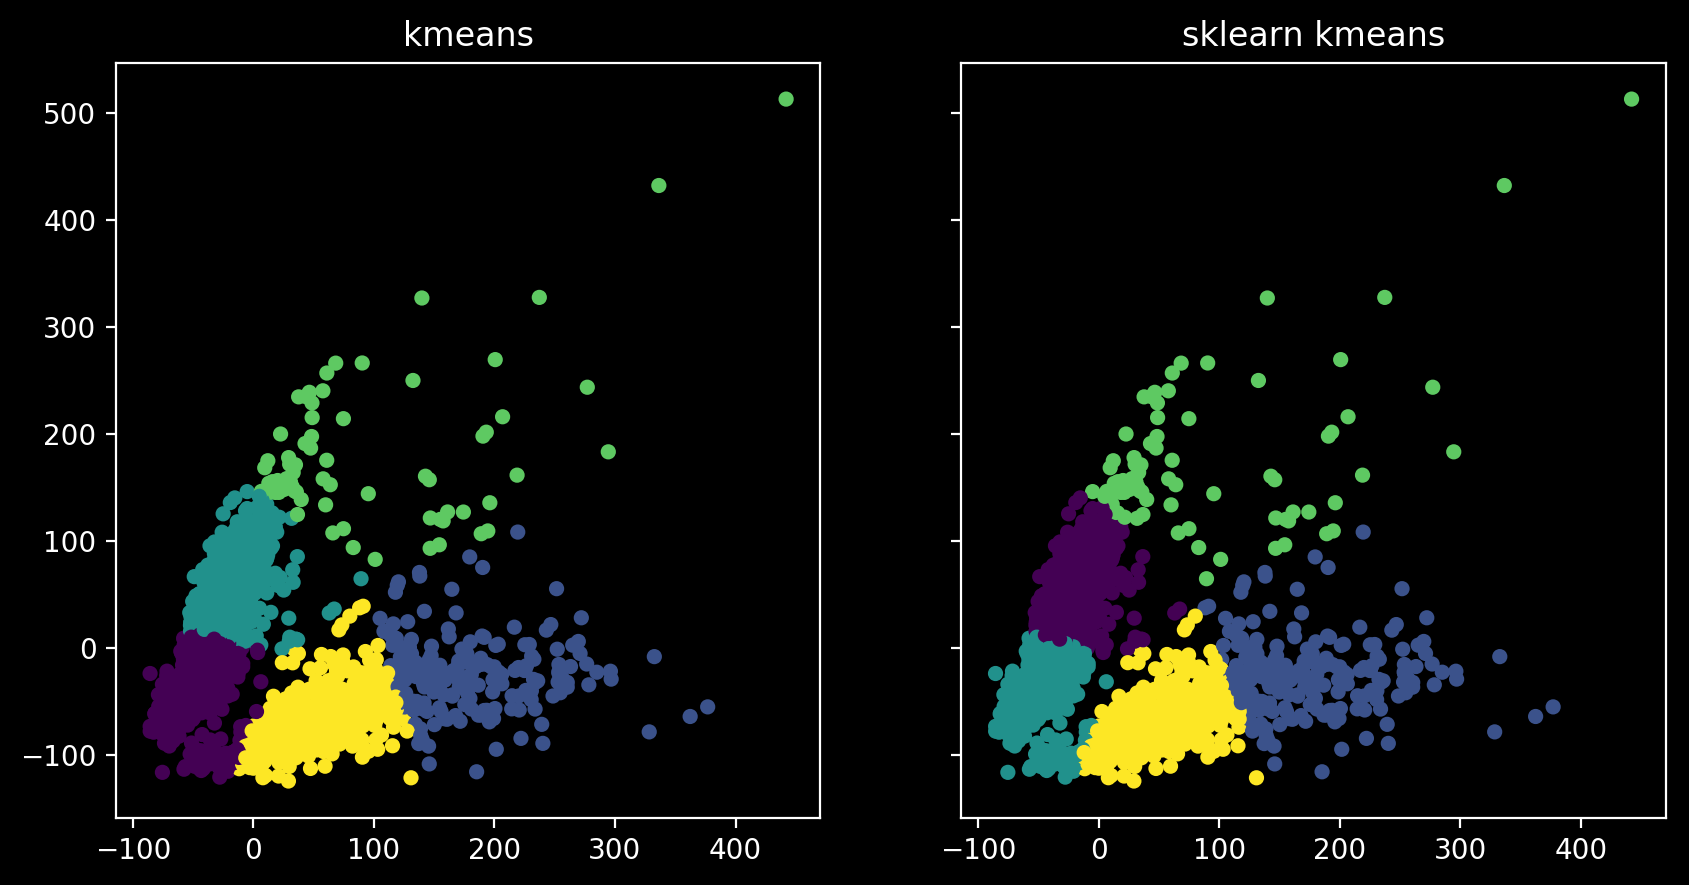

In [34]:
# Import libraries
import numpy as np
import pandas
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import scanpy as sc
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Global Variables
t1 = 0
patients = 0
genes = 0
centroids_array = 0
nearest_centroid = 0
k = 0


# Functions
# Define distance function which takes integer inputs which identify patient and centroid
def runtime_start():
    global t1
    t1 = datetime.now().time()


def runtime_end():
    t2 = datetime.now().time()
    fmt = '%H:%M:%S.%f'
    elapsed = str(datetime.strptime(str(t2), fmt) - datetime.strptime(str(t1), fmt))
    return str("runtime: " + elapsed)


def random_start_centroids(starttype):
    # Create Centroid Array by randomly picking k patients from data
    global centroids_array, patients, genes
    patients = pca_data.shape[0]
    genes = pca_data.shape[1]
    centroids_array = np.empty([0, genes])

    if starttype == "randpat":
        centroids_numbers = np.random.randint(patients, size=k)
        i = 0
        # Pick random start sample 
        while i < k:
            random_patient = centroids_numbers[i]
            centroids_array = np.append(centroids_array, [pca_data[random_patient, :]], axis=0)
            i += 1

    elif starttype == "randnum":
        centroids_array = (np.amax(pca_data) - np.amin(pca_data)) * np.random.random_sample((k, genes)) + np.amin(
            pca_data)


def assign_centroids():
    global nearest_centroid
    # Assign closest Centroid
    # Loop über alle Punkte
    i = 0
    nearest_centroid = np.zeros([patients, 1])
    while i < patients:
        sml_distance = 0

        # While loop selecting every centroid
        j = 1
        while j <= k:

            if sml_distance == 0 or dist(i, j) < sml_distance:
                sml_distance = dist(i, j)
                nearest_centroid[i, 0] = j
            j += 1
        i += 1


def empty_check():
    # Sicherstellen dass es durch die Zufallscentroids keine leeren Cluster gibt
    i = 0
    while i < k:
        if list(nearest_centroid).count(i + 1) == 0:
            print("Empty cluster! Correcting centroids.")
            random_start_centroids("randnum")
            assign_centroids()
            empty_check()
        i += 1


def dist(patient_point, cluster_number):
    a = pca_data[patient_point, :]
    b = centroids_array[cluster_number - 1, :]
    d = np.linalg.norm(a - b)
    return d


def new_centroids():
    global centroids_array
    zeros = np.zeros([patients, 1])
    centroids_array = np.empty([0, genes])
    # "Masken" um values aus pca_data abzurufen
    nearest_centroidpca1 = np.append(nearest_centroid, zeros, axis=1)
    nearest_centroidpca2 = np.append(zeros, nearest_centroid, axis=1)
    # while loop der für alle k cluster läuft:
    i = 1
    while i <= k:
        pca1 = np.mean(pca_data[nearest_centroidpca1 == i])
        pca2 = np.mean(pca_data[nearest_centroidpca2 == i])
        centroids_array = np.append(centroids_array, [[pca1, pca2]], axis=0)
        i += 1


def kmeans(k1, n_iterations):
    global k
    k = k1
    i = 0
    random_start_centroids("randnum")
    assign_centroids()
    empty_check()
    while i < n_iterations:
        new_centroids()
        assign_centroids()
        i += 1


# General Code
# Import data
data = sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19/', var_names='gene_symbols', cache=True)

# Filter useless data
sc.pp.filter_genes(data, min_cells=1)
filtered_data = np.array(data._X.todense())

# PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filtered_data)
# print(sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)


# Execute
runtime_start()
kmeans(5, 10)
print("\nkmeans:")
print(runtime_end())

# plotting
fig = pyplot.figure(1, figsize=[10, 5], dpi=200)
plt1, plt2 = fig.subplots(1, 2, sharex=True, sharey=True)
nearest_centroid_squeeze = np.squeeze(nearest_centroid.astype(int))
plt1.scatter(pca_data[:, 0], pca_data[:, 1], c=nearest_centroid_squeeze, s=20, cmap='viridis')
plt1.set_title('kmeans')
a_str = np.array2string(centroids_array[np.argsort(centroids_array[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + a_str[1:-1])

# sklearn comparison
print("\nsklearn kmeans:")
runtime_start()
sklearn_kmeans = KMeans(n_clusters=k).fit(pca_data)
y_sklearnkmeans = sklearn_kmeans.predict(pca_data)
print(runtime_end())
plt2.scatter(pca_data[:, 0], pca_data[:, 1], c=y_sklearnkmeans, s=20, cmap='viridis')
plt2.set_title('sklearn kmeans')
pyplot.show()
b_str = np.array2string(sklearn_kmeans.cluster_centers_[np.argsort(sklearn_kmeans.cluster_centers_[:, 0])], precision=2, separator=' ')
print("centroids: \n" + ' ' + b_str[1:-1])
